In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [2]:
accuracy_list = {
    "dkd": 67.52,
    "dkd+ours-adjust": 67.72,
    "dkd+ours+adjust": 68.10,
}

In [5]:
accuracy_list = {
    "1": 67.49,
    "2": 67.78,
    "4": 67.64,
    "8": 67.80
}

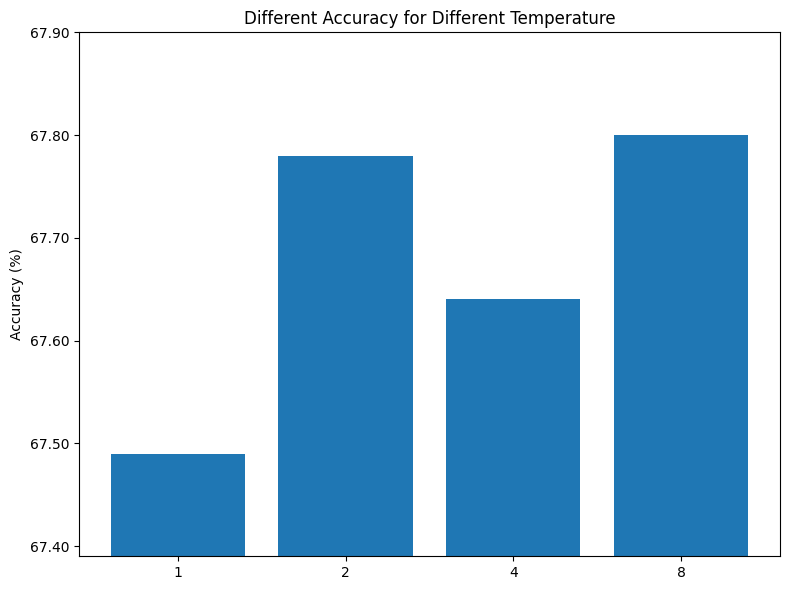

In [6]:
labels = list(accuracy_list.keys())
values = list(accuracy_list.values())

# Find the minimum value to set a lower bound for the y-axis
min_accuracy = min(values)

# Calculate a slightly lower bound to create some visual separation
lower_bound = min_accuracy - 0.1  # Adjust 0.1 as needed

plt.figure(figsize=(8, 6))
plt.bar(labels, values)
plt.ylabel("Accuracy (%)")
plt.title("Different Accuracy for Different Temperature")
plt.ylim(lower_bound, max(values) + 0.1)

# Format the y-axis ticks to show two decimal places
formatter = mticker.FormatStrFormatter('%.2f')
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()